In [24]:
import pandas as pd
dataset_path = "../dataset/extended_dataset.csv"
test__input_path = "./test_split/test_input.csv"
test__target_path = "./test_split/test_target.csv"
model_path = "../models/model_2023_12_07_19_58_30"

In [27]:
dataset_df = pd.read_csv(dataset_path, sep='$', encoding='utf-8')
test_input_df = pd.read_csv(test__input_path, sep='$', encoding='utf-8')
test_target_path = pd.read_csv(test__target_path, sep='$', encoding='utf-8')
test_df = pd.concat([test_input_df, test_target_path], axis=1).drop(columns=['Unnamed: 0'])

In [28]:
shows_df = dataset_df[['show_id', 'show_rating', 'type', 'title']].drop_duplicates()
shows_df

,show_id,show_rating,type,title
0,10014103,8.32095,movie,The Zone of Interest
7,10025735,6.41777,movie,Passages
16,805204,7.41684,movie,Killers of the Flower Moon
40,10034333,7.36086,movie,La passion de Dodin Bouffant
49,10015490,5.44533,movie,Imaculat
...,...,...,...,...
4276,725776,7.36279,tv_series,Humans
4277,698665,7.23548,tv_series,Togetherness
4278,270224,8.11299,tv_series,Moral Orel
4279,10039427,6.82828,tv_series,Superpowered: The DC Story


In [30]:
df = pd.merge(shows_df, test_df, on='title').drop_duplicates()
df

,show_id,show_rating,type,title,user_comment,user_rate
0,575916,7.05974,movie,Tinker Tailor Soldier Spy,"Dawno nie oglądałam tak nudnego filmu, zupełni...",5
1,575916,7.05974,movie,Tinker Tailor Soldier Spy,"Cholernie smutny, cholernie nudny. Byłem w kin...",3
2,575916,7.05974,movie,Tinker Tailor Soldier Spy,to chyba tyle na temat tego filmu :),3
3,575916,7.05974,movie,Tinker Tailor Soldier Spy,Reżyser próbuje budować napięcie w filmie popr...,5
4,575916,7.05974,movie,Tinker Tailor Soldier Spy,miewa ciekawe momenty ale też dużo zamulaczy a...,7
...,...,...,...,...,...,...
5761,792826,8.13358,tv_series,La casa de papel,Super ! Bardzo fajny serial. Czy już wiadomo k...,10
5762,792826,8.13358,tv_series,La casa de papel,"Uwielbiam, mój absolutny TOP seriali. Pochłoną...",10
5763,792826,8.13358,tv_series,La casa de papel,Wpadła mi w ucho ta ludowa piosenka i nie chce...,9
5764,792826,8.13358,tv_series,La casa de papel,Pierwszy sezon to naprawdę wspaniałe widowisko...,10


In [31]:
from transformers import HerbertTokenizer, RobertaModel
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = HerbertTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1")

class HerbertRegressionModel(nn.Module):
    def __init__(self, drop_rate=0.2):
        super(HerbertRegressionModel, self).__init__()
        D_in, D_out = 768, 1
        self.model = RobertaModel.from_pretrained("allegro/herbert-klej-cased-v1")
        self.regressor = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(D_in, D_out))

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask)
        outputs = outputs[1]
        return self.regressor(outputs)

model = HerbertRegressionModel()
model.load_state_dict(torch.load(model_path))
model.to(device=device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMTokenizer'. 
The class this function is called from is 'HerbertTokenizer'.


HerbertRegressionModel(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50560, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [32]:
def pre_parse_dataset(input):
    encoded_corpus = tokenizer(text=input, add_special_tokens=True, padding='max_length', truncation='longest_first', max_length=256, return_attention_mask=True)
    return np.array(encoded_corpus['input_ids']), np.array(encoded_corpus['attention_mask'])


def prepare_dataloader(inputs, masks, target, batch_size):
    input_tensor = torch.tensor(inputs).to(device=device)
    mask_tensor = torch.tensor(masks).to(device=device)
    labels_tensor = torch.tensor(target).to(device=device)
    dataset = TensorDataset(input_tensor, mask_tensor, labels_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [33]:
X_test = df['user_comment']
y_test = df['user_rate'].to_numpy().reshape(-1, 1)
test_input_id, test_attention_mask = pre_parse_dataset(X_test.tolist())
test_dataloader = prepare_dataloader(test_input_id, test_attention_mask, y_test, 1)

In [35]:
def predict_rating(model, dataloader):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = batch
        with torch.no_grad():
            output += model(batch_inputs, batch_masks).view(1,-1).tolist()[0]
    return [round(o) for o in output]


In [36]:
y_predicted = predict_rating(model, dataloader=test_dataloader)

In [40]:
df['predicted'] = y_predicted
df

,show_id,show_rating,type,title,user_comment,user_rate,predicted
0,575916,7.05974,movie,Tinker Tailor Soldier Spy,"Dawno nie oglądałam tak nudnego filmu, zupełni...",5,3
1,575916,7.05974,movie,Tinker Tailor Soldier Spy,"Cholernie smutny, cholernie nudny. Byłem w kin...",3,5
2,575916,7.05974,movie,Tinker Tailor Soldier Spy,to chyba tyle na temat tego filmu :),3,5
3,575916,7.05974,movie,Tinker Tailor Soldier Spy,Reżyser próbuje budować napięcie w filmie popr...,5,5
4,575916,7.05974,movie,Tinker Tailor Soldier Spy,miewa ciekawe momenty ale też dużo zamulaczy a...,7,7
...,...,...,...,...,...,...,...
5761,792826,8.13358,tv_series,La casa de papel,Super ! Bardzo fajny serial. Czy już wiadomo k...,10,6
5762,792826,8.13358,tv_series,La casa de papel,"Uwielbiam, mój absolutny TOP seriali. Pochłoną...",10,7
5763,792826,8.13358,tv_series,La casa de papel,Wpadła mi w ucho ta ludowa piosenka i nie chce...,9,6
5764,792826,8.13358,tv_series,La casa de papel,Pierwszy sezon to naprawdę wspaniałe widowisko...,10,7


In [47]:
movie_results = df.groupby('title')[['show_rating', 'user_rate', 'predicted']].mean()
movie_results

,show_rating,user_rate,predicted
title,,,
2001: A Space Odyssey,7.734830,7.886364,6.340909
365 dni,3.501040,3.083333,6.062500
Alien: Covenant,5.710040,5.428571,6.238095
Amadeus,8.141120,8.945946,6.081081
American Gangster,7.794020,8.060606,6.212121
...,...,...,...
Westworld,7.869710,7.200000,6.320000
Wyjazd integracyjny,3.528380,4.470588,6.382353
Zielona granica,4.172640,4.019608,6.274510


In [53]:
movie_results['error'] = movie_results['show_rating'] - movie_results['predicted']
movie_results['error'] = movie_results['error'].abs()
movie_results

,show_rating,user_rate,predicted,error
title,,,,
2001: A Space Odyssey,7.734830,7.886364,6.340909,1.393921
365 dni,3.501040,3.083333,6.062500,2.561460
Alien: Covenant,5.710040,5.428571,6.238095,0.528055
Amadeus,8.141120,8.945946,6.081081,2.060039
American Gangster,7.794020,8.060606,6.212121,1.581899
...,...,...,...,...
Westworld,7.869710,7.200000,6.320000,1.549710
Wyjazd integracyjny,3.528380,4.470588,6.382353,2.853973
Zielona granica,4.172640,4.019608,6.274510,2.101870


In [55]:
count_below_threshold = (movie_results['error'] < 0.5).sum()
print(f"Number of films where the predicted rating is +- 0.5 is equal to {count_below_threshold}")

Number of films where the predicted rating is +- 0.5 is equal to 6


In [56]:
movie_results.describe()['error']

count    97.000000
mean      1.580433
std       0.624290
min       0.257073
25%       1.123485
50%       1.630280
75%       2.019630
max       2.853973
Name: error, dtype: float64

<Axes: >

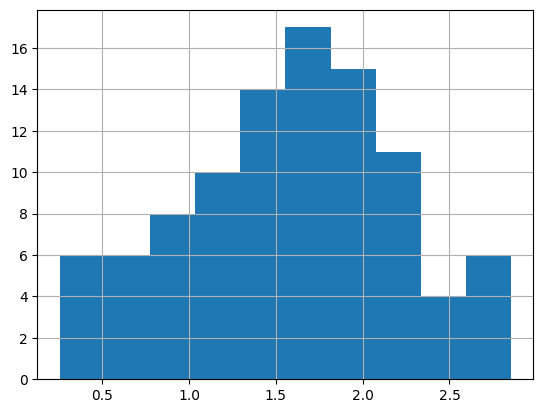

In [57]:
movie_results['error'].hist()